# Comparing Dinucleotide Positional Features 

## Setting up

In [1]:
import pickle 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import re
import seaborn as sns

In [2]:
# tools which use the dinucleotide positional features 
tools_of_interest = ['tuscan-classification' ,'tuscan-regression','chop-chop-doench']
dataset_name = 'doench'

In [3]:
# dictionary from tool to (feature_name, shap_values)
shap_values_by_tool = dict.fromkeys(tools_of_interest)

In [4]:
# all the possible dinucleotide features 
nucs = ['A', 'C', 'G', 'T']

all_features = []
for n1 in nucs: 
    for n2 in nucs: 
        for p in range(0,20):
            feature = n1 + n2 + str(p)
            all_features.append(feature)
            


In [5]:
# given a feature name, matches the content and returns the match (None if not dinucleotide)
def is_dinucleotide(feature_name):
    
    # tuscan has NN:pos chop chop has NNpos
    m = re.match(r"^(?P<nuc1>[ACGT])(?P<nuc2>[ACGT])(:)?(?P<pos>([0-9])*)$", feature_name)
    
    return m

## Compute the average SHAP value for each feature and tool 
The average SHAP value is calculated over the data points which have the feature set to 1

In [6]:
# Compute one value per feature-tool 

shap_dict = {}

for t in tools_of_interest: 
    pickle_name = "./pickles/SHAP-" + str(t) + "-" + str(dataset_name)
    shap_dict[t] = {}
    
    # load the shap values and dataset values
    p = open(pickle_name, "rb")
    shap_values = pickle.load(p)
    dataset = pickle.load(p)
    p.close()
    
    # format a bit the shap values
    features = dataset.columns
    shap_values = pd.DataFrame(shap_values,columns = features)
    dataset = pd.DataFrame(dataset)
    
    # only keep dinucleotide features 
    dinuc_features = [f for f in features if is_dinucleotide(f)]
    shap_values = shap_values[dinuc_features]
    dataset = dataset[dinuc_features]
    
    # eliminate columns with only 0s
    shap_values = shap_values.loc[:, (shap_values != 0.0).any(axis=0)]
    
    # calculate the average over positively set data points
    for f in dinuc_features: 
        if f not in shap_values.columns:
            continue
        data_feature_values = dataset[f]
        shap_feature_values = shap_values[f]
        
        # get the indices of data points which have the feature set to 1
        data_indices = [] 
        for i,d in enumerate(data_feature_values):
            if d: 
                data_indices.append(i)
        
        # only keep positive data 
        data_feature_values = data_feature_values[data_feature_values.index.isin(data_indices)]
        shap_feature_values = shap_feature_values[shap_feature_values.index.isin(data_indices)]
        
        # compute average shap value
        average_shap_value_feature = shap_feature_values.mean()
       
        new_f_name = f.replace(':','')
        shap_dict[t][new_f_name] = average_shap_value_feature

shap_dict
        
    
    
    

{'tuscan-classification': {'CG6': 0.0151457099044574,
  'GA10': 0.034044026554175495,
  'TT11': -0.031627324214598636,
  'CC15': 0.031013767682227522,
  'TA17': -0.05549821115203807,
  'CG18': 0.03525708538676285,
  'TC18': -0.040220485979615944,
  'TG18': 0.03609145066650492,
  'CC19': 0.027564452442044415,
  'GA19': 0.012922981464798153,
  'GC19': 0.08251447522548144,
  'GT19': 0.010779052274464757,
  'TC19': -0.0180529398195135},
 'tuscan-regression': {'GA0': 0.176730270525426,
  'CT1': 0.4232435852994785,
  'AC3': 0.15033671656510733,
  'CC3': 0.2173823958801216,
  'GA3': 0.1702892077822632,
  'TT4': 0.05478198136874924,
  'AT5': -0.03349707215462011,
  'CG6': 0.42009433652300954,
  'GA7': 0.05112215292899101,
  'CC9': 0.18817112531015348,
  'GA10': 0.2537894906542112,
  'CC11': 0.07051142043281541,
  'GG11': 0.18873851613337916,
  'TT11': -0.03574541066498564,
  'CT12': 0.09310365560958363,
  'AA13': 0.0470216439148036,
  'GG14': 0.23904248022886465,
  'AT15': 0.09284989618489844,

## Scale values by tool 

The SHAP values of positional dinucleotides are scaled by tool, such that in each tool the pos dinuc feature with the highest (positive/negative) impact has SHAP value of (+/-)1. The scaling is by absolute value, such that it maintains the sign of the impact and only scales the absolute value. 

In [7]:
def scale_by_tool(tool_dict):
    vals = list(tool_dict.values())
   
    max_val = max(vals)
    min_val = min(vals)
    
    # maximum by absolute value in the list (all shap values for positional dinucleotide features)
    max_abs = abs(min_val)
    if abs(max_val) > abs(min_val):
        max_abs = abs(max_val) 
        
    # divide by the max_abs in the list
    new_dict = {}
    for k in tool_dict:
        new_dict[k] = tool_dict[k] / max_abs
    
    return new_dict
    

In [8]:
for tool in tools_of_interest:
    shap_dict[tool] = scale_by_tool(shap_dict[tool])


## Compare these values across tools

## Those dinucleotide positional features which have at least one average non-0

In [9]:
interesting_features = []
interesting_feature_values = []
for f in all_features:
    vals = []
    for tool in tools_of_interest: 
        if f not in shap_dict[tool].keys():
            vals.append(0)
            continue
        val = shap_dict[tool][f]
        vals.append(val)
        
    if np.any(vals): # not all 0s
        interesting_features.append(f)
        interesting_feature_values.append(vals)
        
cols = tools_of_interest
interesting_feature_df = pd.DataFrame(interesting_feature_values, columns = cols)
interesting_feature_df.index = interesting_features
interesting_feature_df
        

,tuscan-classification,tuscan-regression,chop-chop-doench
AA2,0.000000,0.000000,-0.550565
AA13,0.000000,0.081981,0.000000
AC3,0.000000,0.262108,0.000000
AG10,0.000000,0.000000,0.504003
AG17,0.000000,0.000000,-0.551555
AT2,0.000000,0.000000,0.501797
AT5,0.000000,-0.058401,0.000000
AT8,0.000000,0.000000,0.467943
AT15,0.000000,0.161881,0.000000
CA17,0.000000,0.000000,0.374974


## Those dinucleotide positional features which have at least 2 non-0 averages

In [10]:
more_interesting_feature_df = interesting_feature_df.loc[(interesting_feature_df['tuscan-classification'] == 0.0) 
                                                         ^ (interesting_feature_df['tuscan-regression'] == 0.0) 
                                                         ^ (interesting_feature_df['chop-chop-doench'] == 0.0)]



In [11]:
more_interesting_feature_df

,tuscan-classification,tuscan-regression,chop-chop-doench
CC15,0.375859,0.711139,0.000000
CG6,0.183552,0.732424,0.000000
CG18,0.427284,0.050914,0.000000
CT15,0.000000,0.279753,0.233184
GA10,0.412582,0.442475,0.000000
GA19,0.156615,0.025223,0.000000
GG15,0.000000,-0.090019,-0.439638
GT19,0.130632,0.008737,0.000000
TA17,-0.672588,-0.075905,0.000000
TC19,-0.218785,0.004853,0.000000


## Make sense of results 

In [12]:
df = more_interesting_feature_df

### Compute the average over the 3 tools for all of the features

In [13]:
summary_ave_data = df.copy()
summary_ave_data['average'] = summary_ave_data.mean(numeric_only=True, axis=1)
summary_ave_data.head()

,tuscan-classification,tuscan-regression,chop-chop-doench,average
CC15,0.375859,0.711139,0.000000,0.362333
CG6,0.183552,0.732424,0.000000,0.305325
CG18,0.427284,0.050914,0.000000,0.159399
CT15,0.000000,0.279753,0.233184,0.170979
GA10,0.412582,0.442475,0.000000,0.285019


### Sort by average

In [14]:
summary_ave_data = summary_ave_data.sort_values('average')
summary_ave_data.head()

,tuscan-classification,tuscan-regression,chop-chop-doench,average
TA17,-0.672588,-0.075905,0.000000,-0.249497
GG15,0.000000,-0.090019,-0.439638,-0.176552
TT11,-0.383294,-0.062321,0.000000,-0.148538
TC19,-0.218785,0.004853,0.000000,-0.071311
GT19,0.130632,0.008737,0.000000,0.046456


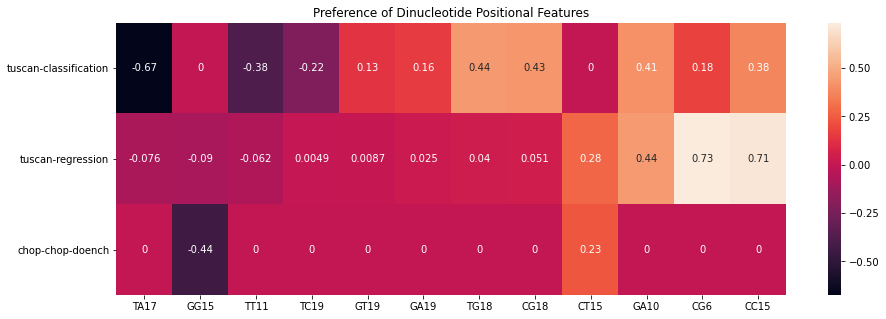

In [15]:
plt.figure(figsize=(15,5))
plt.title("Preference of Dinucleotide Positional Features")
sns.heatmap(summary_ave_data.drop('average',1).transpose(), annot=True)
plt.savefig('./plots/dinucsDo.png')

## Interpretations

* negative TA17 : Thymine is generally disfavoured towards the end of the guide
* positive CT15 : Cytosine preferred in position 15 + Thymine preferred in 16 (especially by tuscan-classification and chop-chop-doench)
* positive GA10 : Adenine preferred in position 11 + Guanine just generally preferred
* positive CG6 : Cytosive is preferred in position 6 by all models besides tuscan-classification and chop-chop-doench. This shows the importance despite C6 itself having small value
* positive CC15 : Again cytosine preferred in position 15. And CC15 has higher values than CT15 overall 